In [51]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import exposure, filters, measure, morphology, segmentation, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I43.09

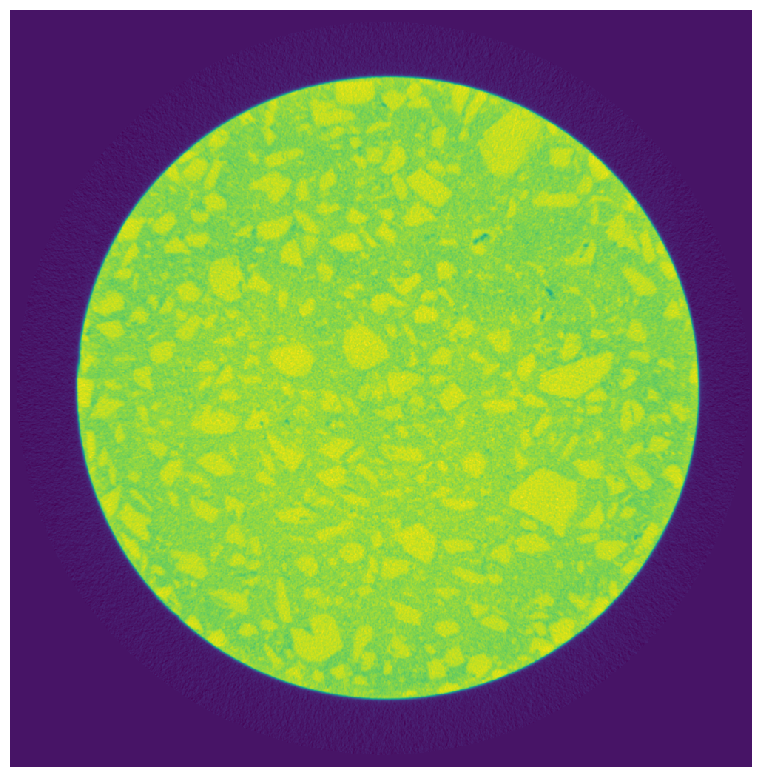

In [2]:
img_path = (
    r'C:\Users\cgusb\Research\mhe-analysis\data\I43\bin-2-tiffs\0506.tiff')
img = iio.imread(img_path)
fig, ax = view.images(img)

### Multi Otsu

Calculating Multi Otsu thresholds...
[0.00464154 0.00960682]


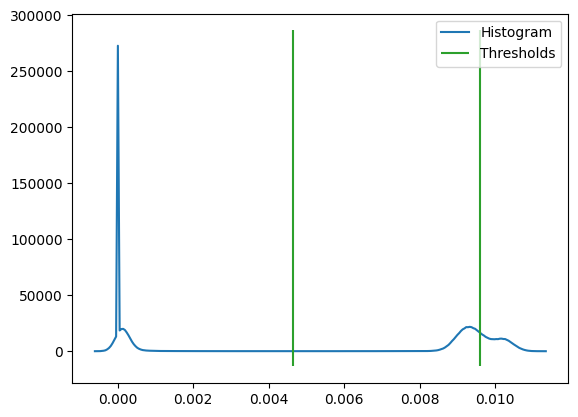

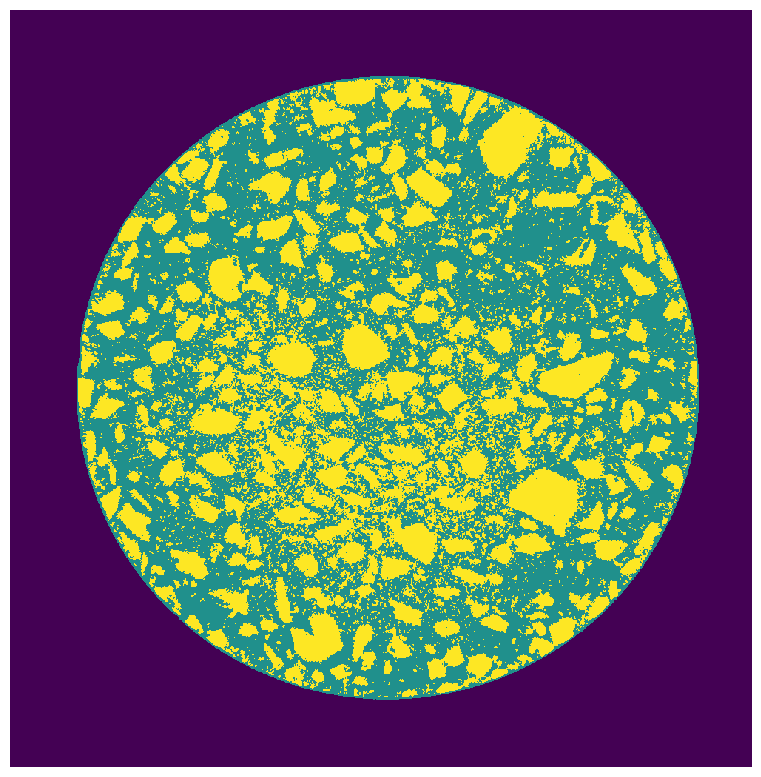

In [25]:
img_med = filters.median(img)
thresh_vals, fig, ax = segment.threshold_multi_otsu(
    img, nclasses=3, return_fig_ax=True)
print(thresh_vals)
img_semantic = np.zeros_like(img, dtype=np.uint8)
for i, val in enumerate(thresh_vals):
    img_semantic[img > val] = int((i + 1))
fig, ax = view.images(img_semantic)

Calculating Multi Otsu thresholds...
[0.00464154 0.00960682]


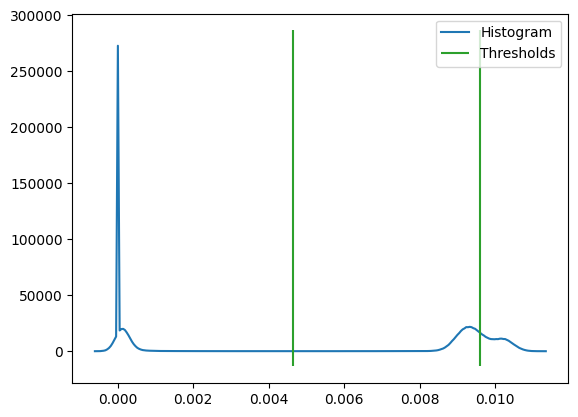

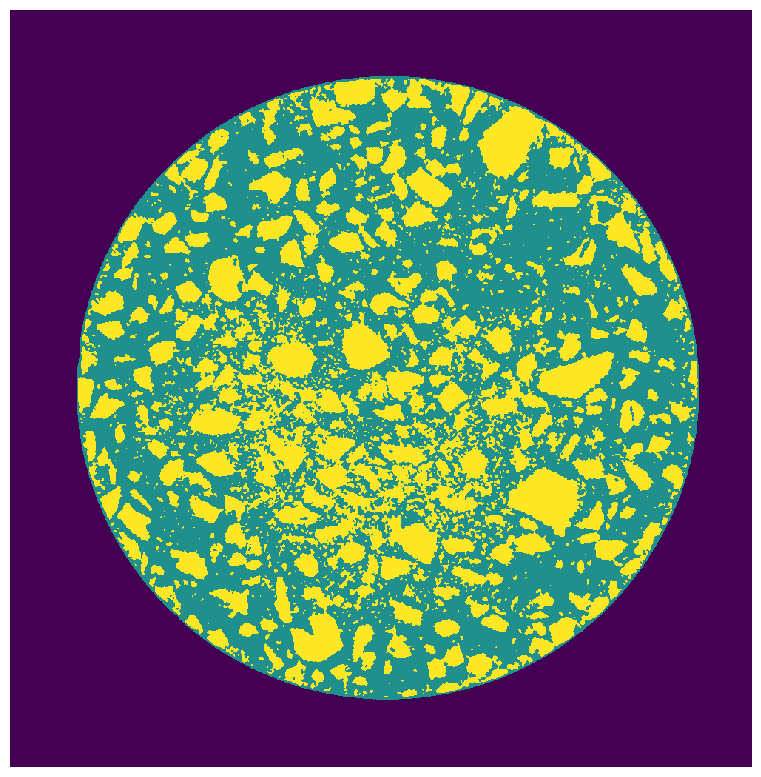

In [24]:
img_med = filters.median(img)
thresh_vals, fig, ax = segment.threshold_multi_otsu(
    img, nclasses=3, return_fig_ax=True)
print(thresh_vals)
med_semantic = np.zeros_like(img, dtype=np.uint8)
for i, val in enumerate(thresh_vals):
    med_semantic[img_med > val] = int((i + 1))
fig, ax = view.images(med_semantic)

(<Figure size 750x382.851 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

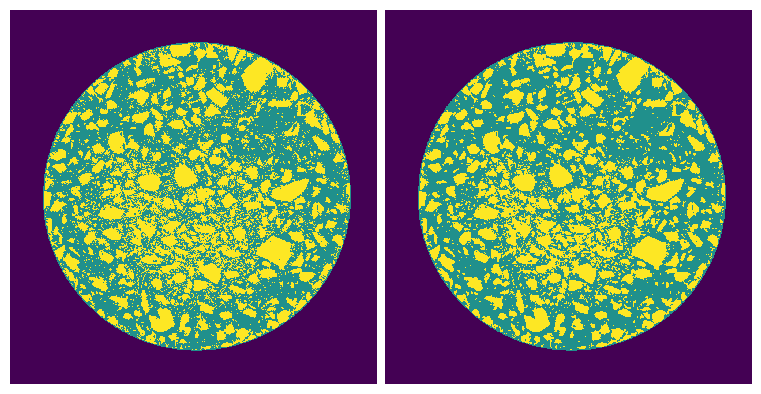

In [27]:
view.images([img_semantic, med_semantic])

### Equalize hist

Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...
Calculating Multi Otsu thresholds...


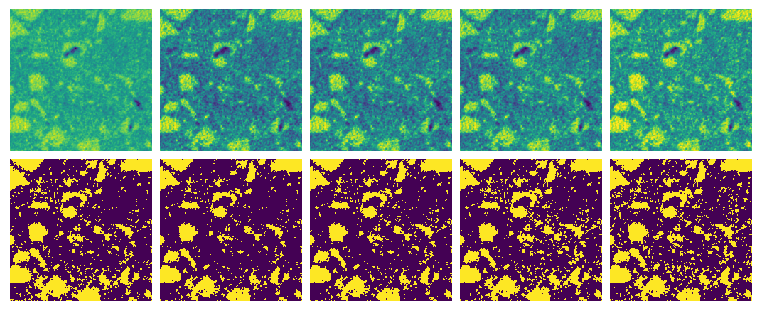

In [48]:
%matplotlib inline
# %matplotlib qt
eqs = {}
for denom in [4, 8, 16, 32]:
    eqs[denom] = exposure.equalize_adapthist(
        img, kernel_size=img.shape[0]//denom)
eq_sems = {}
for denom, eq in eqs.items():
    thresh_vals = segment.threshold_multi_otsu(eq, nclasses=3)
    eq_sems[denom] = np.zeros_like(img, dtype=np.uint8)
    for i, val in enumerate(thresh_vals):
        eq_sems[denom][eq > val] = int((i + 1))
view_imgs = [img, *eqs.values(), img_semantic, *eq_sems.values()]
view_range = [250, 450, 550, 750]
fig, ax = view.images(
    [i[view_range[0]:view_range[1], view_range[2]:view_range[3]] for i in view_imgs],
    imgs_per_row=len(eqs.keys())+1)

### Manual Semantic Segmentation

Loading images...
--> Images loaded as 3D array:  (1012, 1024, 1003)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [24.8, 99.9]...
--> Preprocessing complete.
--> Plotting images: [   0  505 1011]


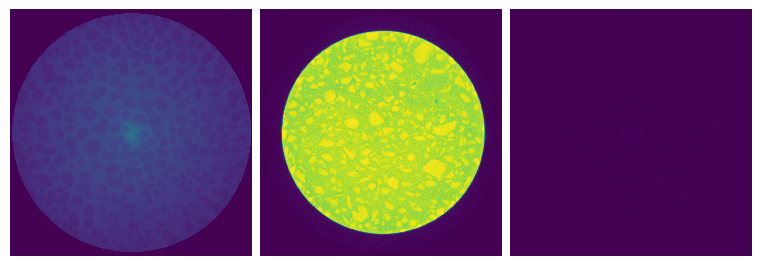

In [67]:
dir_path = (
    r'C:\Users\cgusb\Research\mhe-analysis\data\I43.09\bin-2-tiffs')
imgs = segment.load_images(dir_path)
imgs = segment.preprocess(
    imgs,
    median_filter=True,
    rescale_intensity_range=[24.8, 99.9]
)
fig, axes = view.vol_slices(imgs)

--> Plotting images: [250, 500, 750]


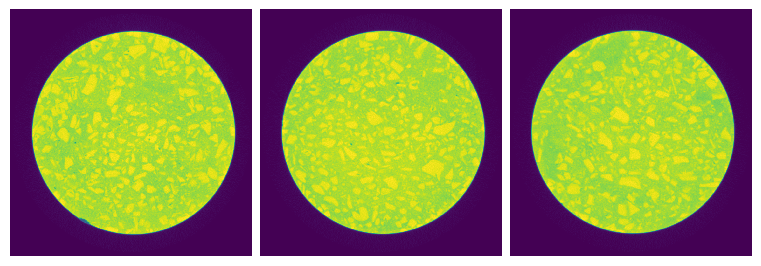

In [73]:
fig, axes = view.vol_slices(imgs, slices=[250, 500, 750])

Generating histogram...


(0.0, 50000000.0)

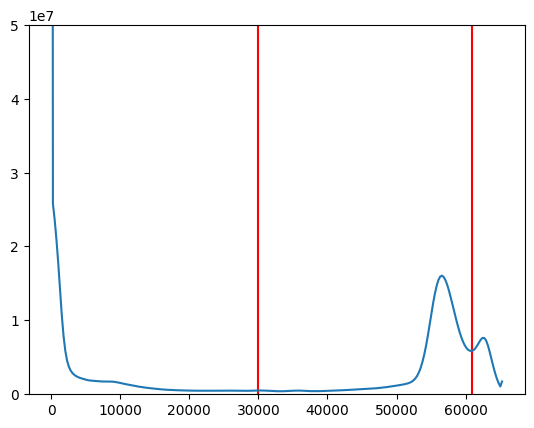

In [74]:
fig, ax = view.histogram(imgs, mark_values=[3E4, 6.1E4])
ax.set_ylim([0, 5E7])

--> Plotting images: [250, 500, 750]


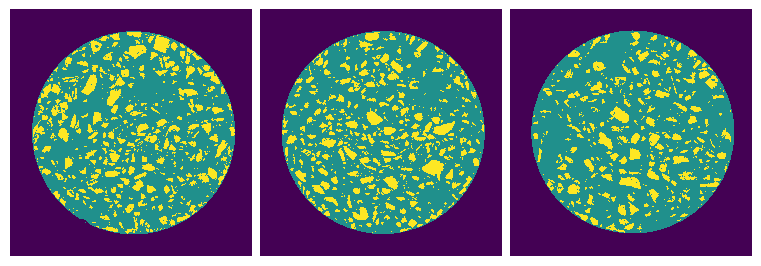

In [75]:
thresh_vals = [3E4, 6.1E4]
imgs_semantic = segment.isolate_classes(imgs, thresh_vals)
fig, axes = view.vol_slices(imgs_semantic, slices=[250, 500, 750])

In [89]:
ums_per_pixel = 6.010528
print(45 / ums_per_pixel)
print(8 * ums_per_pixel)
print(8**3)

7.486863050966571
48.084224
512


--> Plotting images: [250, 500, 750]


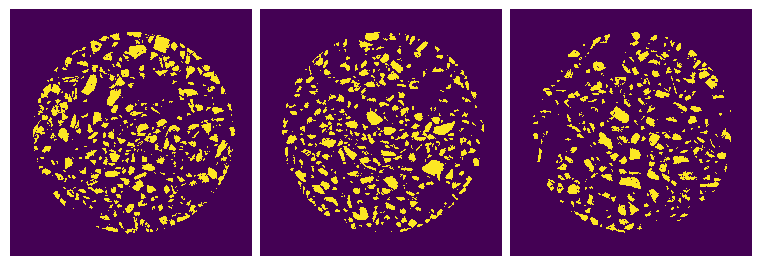

In [86]:
grains_filtered = morphology.remove_small_objects(imgs_semantic==2, min_size=8**3)
fig, axes = view.vol_slices(grains_filtered, slices=[250, 500, 750])

In [87]:
imgs_semantic_rm = imgs_semantic.copy()
imgs_semantic_rm[imgs_semantic == 2] = 1
imgs_semantic_rm[grains_filtered==True] = 2

(<Figure size 750x375 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

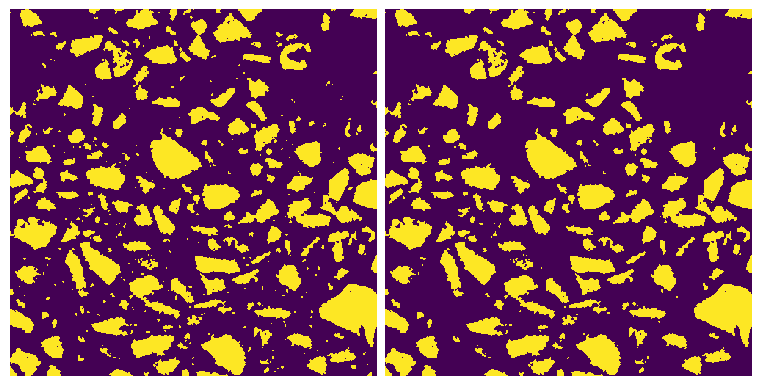

In [88]:
crop = [250, 250, 750, 750]
views = [
    im[crop[0]:crop[2], crop[1]:crop[3]]
    for im in [imgs_semantic[500, ...], imgs_semantic_rm[500, ...]]]
view.images(views)

## Under 45ums

Loading images...
--> Images loaded as 3D array:  (200, 2030, 1982)
(200, 2030, 1982)
(2030, 1982)


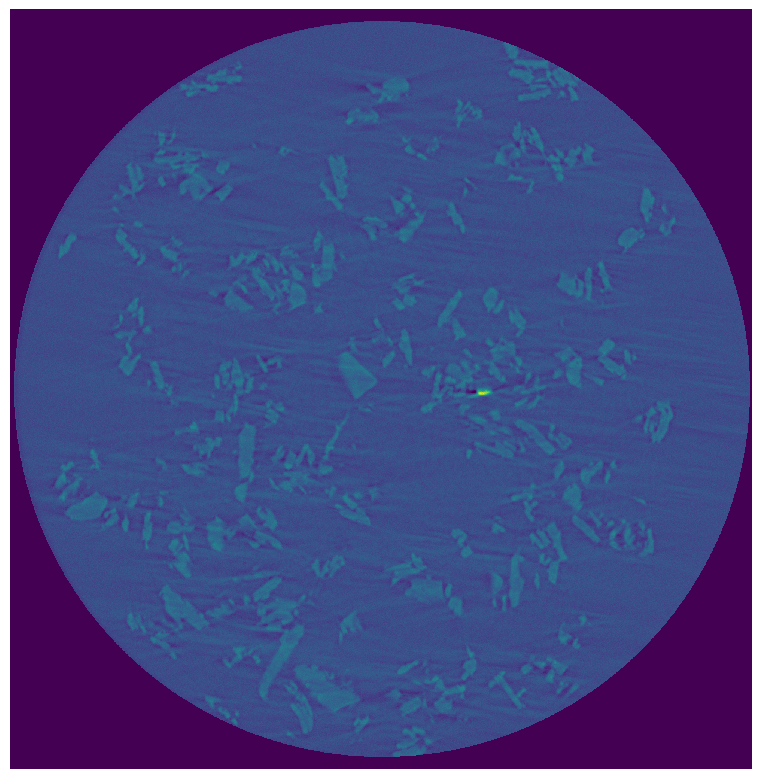

In [49]:
dir_path = Path(
    r'C:\Users\cgusb\Research\mhe-analysis\data'
    r'\Ptcls_IDOXcapillary_under45um\test_1')
img = segment.load_images(dir_path, slice_crop=[900, 1100])
view.images(img[100, ...])
print(img.shape)
img = img[100, ...]
print(img.shape)

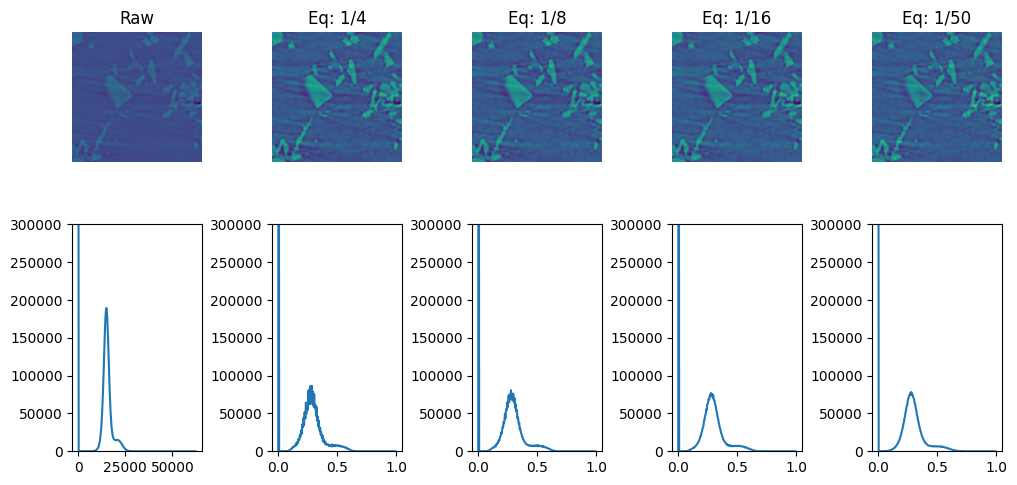

In [42]:
img_eqs = {}
img_eqs[4] = exposure.equalize_adapthist(img, kernel_size=img.shape[0]//4)
img_eqs[8] = exposure.equalize_adapthist(img, kernel_size=img.shape[0]//8)
img_eqs[16] = exposure.equalize_adapthist(img, kernel_size=img.shape[0]//16)
img_eqs[50] = exposure.equalize_adapthist(img, kernel_size=img.shape[0]//50)
fig, axes = plt.subplots(
    2, len(img_eqs.keys())+1, figsize=(10, 5), constrained_layout=True)
axes[0, 0].imshow(img[750:1250, 750:1250], vmin=0, vmax=2**16)
axes[0, 0].set_title(f'Raw')
axes[0, 0].axis('off')
hist, bins_edges = np.histogram(img, bins=256)
axes[1, 0].plot(bins_edges[:-1], hist)
axes[1, 0].set_ylim([0, 3E5])
for i, (denom, im) in enumerate(img_eqs.items()):
    axes[0, i+1].set_title(f'Eq: 1/{denom}')
    axes[0, i+1].imshow(im[750:1250, 750:1250], vmin=0, vmax=1)
    axes[0, i+1].axis('off')
    hist, bins_edges = np.histogram(im, bins=256)
    axes[1, i+1].plot(bins_edges[:-1], hist)
    axes[1, i+1].set_ylim([0, 3E5])

(<Figure size 750x750 with 1 Axes>, <AxesSubplot:>)

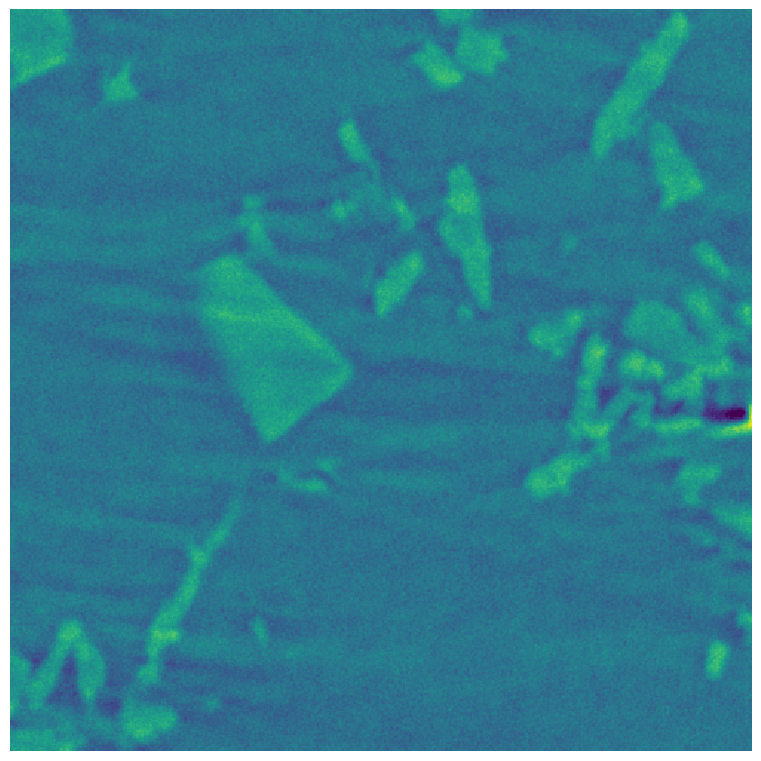

In [14]:
img = img[100, 750:1250, 750:1250]
view.images(img)

Generating histogram...


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

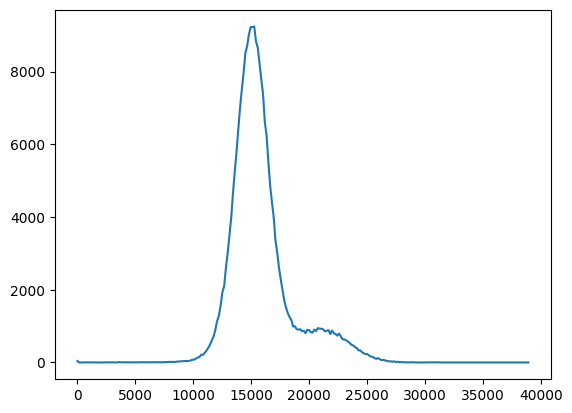

In [15]:
view.histogram(img)

(<Figure size 375x375 with 1 Axes>, <AxesSubplot:>)

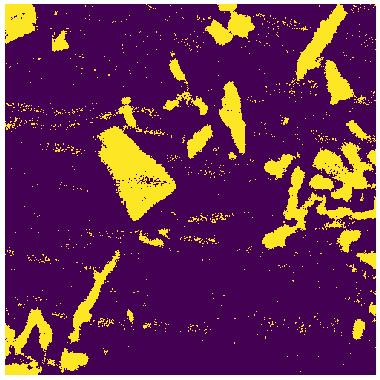

In [18]:
view.images(img>18000, dpi=50)

In [43]:
spatial_res = 2.02  # ums/pixel
xmin =  [22.21810722, 33.74093628,  5.62373495]
xmax =  [3893.55957031, 3905.359375,   2458.84350586]
dims = [spatial_res * (xmax[i] - xmin[i]) for i in range(3)]
print(dims)

[7820.109755441799, 7820.6692462144, 4955.503937238199]
